In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adam
import tensorflow as tf

2024-06-23 18:01:11.991026: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-23 18:01:12.654799: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-23 18:01:13.776564: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/felipe/miniconda3/envs/tf/lib/
2024-06-23 18:01:13.777125: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugi

In [2]:
# load in the data
df = pd.read_csv('./data_clean/ratings.csv')
df.head(5)

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1246,5.0,1425941556
4,1,1968,4.0,1425942148


In [3]:
df["movieId"].unique().__len__()

7565

In [4]:
N = df.userId.max() + 1 # number of users
M = df.movieId.max() + 1 # number of movies

In [5]:
# split into train and test
df = shuffle(df)
cutoff = int(0.8*len(df))
df_train = df.iloc[:cutoff]
df_test = df.iloc[cutoff:]

In [14]:
# initialize variables
K = 5  # Dimensionalidad latente
mu = (
    df_train.rating.mean()
)  # Media de las calificaciones en el conjunto de entrenamiento
epochs = 15  # Número de épocas para el entrenamiento
reg = 0.0  # Penalización de regularización (valor inicializado a 0)

# keras model
u = Input(shape=(1,))  # Capa de entrada para el usuario (1 dimensión)
m = Input(shape=(1,))  # Capa de entrada para la película (1 dimensión)

# Capa de embedding para usuarios (N usuarios, K dimensiones)
u_embedding = Embedding(N, K, embeddings_regularizer=l2(reg))(u)
# Capa de embedding para películas (M películas, K dimensiones)
m_embedding = Embedding(M, K, embeddings_regularizer=l2(reg))(m)

# Sesgo de usuario (N usuarios, 1 dimensión)
u_bias = Embedding(N, 1, embeddings_regularizer=l2(reg))(u)
# Sesgo de película (M películas, 1 dimensión)
m_bias = Embedding(M, 1, embeddings_regularizer=l2(reg))(m)

# Producto punto entre embeddings de usuario y película (N usuarios, 1 película, 1 dimensión)
x = Dot(axes=2)([u_embedding, m_embedding])

# Añadir sesgos al producto punto
x = Add()([x, u_bias, m_bias])

# Aplanar el tensor resultante a una dimensión (N, 1)
x = Flatten()(x)

# Definir el modelo con entradas u y m, y salida x
model = Model(inputs=[u, m], outputs=x)

# Compilar el modelo con función de pérdida MSE, optimizador SGD y métrica de MSE
model.compile(
    loss="mse",
    optimizer=SGD(learning_rate=0.08, momentum=0.9),
    metrics=["mse"],
)

# Mostrar un resumen del modelo
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 1, 5)         1354485     ['input_3[0][0]']                
                                                                                                  
 embedding_5 (Embedding)        (None, 1, 5)         881370      ['input_4[0][0]']                
                                                                                            

In [15]:
r = model.fit(
  x=[df_train.userId.values, df_train.movieId.values],
  y=df_train.rating.values - mu,
  epochs=epochs,
  batch_size=128,
  validation_data=(
    [df_test.userId.values, df_test.movieId.values],
    df_test.rating.values - mu
  )
)

Epoch 1/15
71499/71499 [==============================] - 272s 4ms/step - loss: 0.8447 - mse: 0.8447 - val_loss: 0.8045 - val_mse: 0.8045
Epoch 2/15
71499/71499 [==============================] - 275s 4ms/step - loss: 0.7809 - mse: 0.7809 - val_loss: 0.7649 - val_mse: 0.7649
Epoch 3/15
71499/71499 [==============================] - 256s 4ms/step - loss: 0.7218 - mse: 0.7218 - val_loss: 0.7232 - val_mse: 0.7232
Epoch 4/15
71499/71499 [==============================] - 262s 4ms/step - loss: 0.6710 - mse: 0.6710 - val_loss: 0.7068 - val_mse: 0.7068
Epoch 5/15
71499/71499 [==============================] - 292s 4ms/step - loss: 0.6398 - mse: 0.6398 - val_loss: 0.7003 - val_mse: 0.7003
Epoch 6/15
71499/71499 [==============================] - 279s 4ms/step - loss: 0.6204 - mse: 0.6204 - val_loss: 0.6983 - val_mse: 0.6983
Epoch 7/15
71499/71499 [==============================] - 280s 4ms/step - loss: 0.6072 - mse: 0.6072 - val_loss: 0.6973 - val_mse: 0.6973
Epoch 8/15
71499/71499 [==========

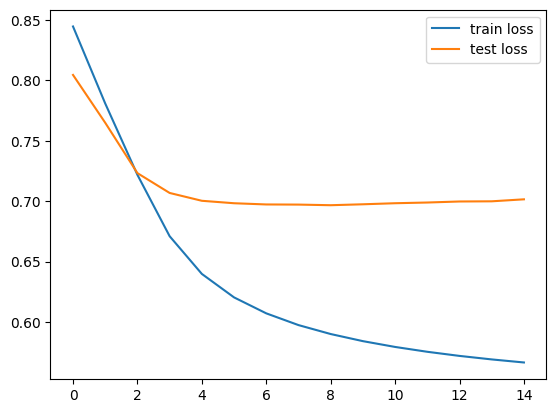

In [16]:
# plot losses
plt.plot(r.history['loss'], label="train loss")
plt.plot(r.history['val_loss'], label="test loss")
plt.legend()
plt.show()

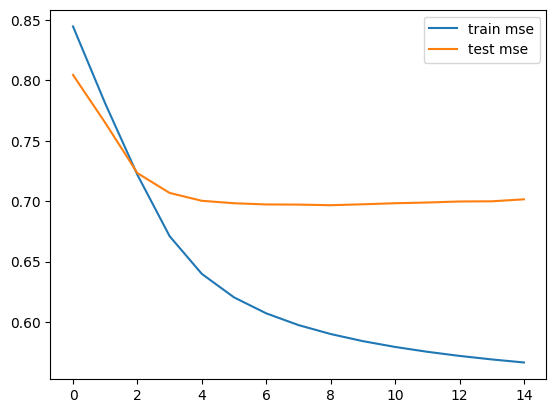

In [17]:
# plot mse
plt.plot(r.history['mse'], label="train mse")
plt.plot(r.history['val_mse'], label="test mse")
plt.legend()
plt.show()

In [18]:
model.save('model_CF.h5')

In [16]:
model =  tf.keras.models.load_model('model_CF.h5')

In [7]:
# Datos para recomendar
user_id = 1
movie_ids = np.array(df["movieId"].values[:400])  # IDs de películas disponibles

# Crear las entradas para el modelo
user_ids = np.full(len(movie_ids), user_id)

# Hacer predicciones
predicted_ratings = model.predict([user_ids, movie_ids])

# Seleccionar las mejores recomendaciones
top_indices = np.argsort(predicted_ratings[:, 0])[::-1]
top_movie_ids = movie_ids[top_indices]

print(
    "Películas recomendadas para el usuario {}: {}".format(user_id, top_movie_ids[:50])
)

13/13 [==============================] - 1s 4ms/step
Películas recomendadas para el usuario 1: [ 2731  4973  4973  4973  1273  1273 44555    58  3022   714   800  3093
   232   233   902 39183 25898  3632  2927    17    17    17 46578   215
 25769  2186  2333  1252   936  2395   342   608   608   924   924  1921
  4979  2324  1365   745   613   176  3476  2594   551   778   685  2313
  2313 26974]


# EXPLICALABILIDAD

## Prueba 1

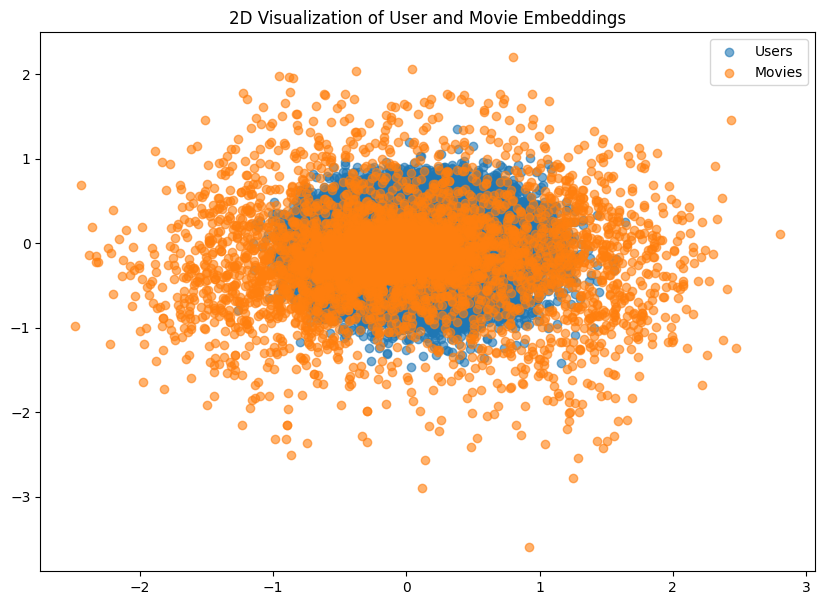

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Obtener embeddings de usuarios y películas
user_embeddings = model.get_layer('embedding_4').get_weights()[0]
movie_embeddings = model.get_layer('embedding_5').get_weights()[0]

# Usar PCA para reducir dimensionalidad a 2D
pca = PCA(n_components=2)
user_embeddings_2d = pca.fit_transform(user_embeddings)
movie_embeddings_2d = pca.fit_transform(movie_embeddings)

# Visualizar embeddings
plt.figure(figsize=(10, 7))
plt.scatter(user_embeddings_2d[:, 0], user_embeddings_2d[:, 1], label='Users', alpha=0.6)
plt.scatter(movie_embeddings_2d[:, 0], movie_embeddings_2d[:, 1], label='Movies', alpha=0.6)
plt.legend()
plt.title('2D Visualization of User and Movie Embeddings')
plt.show()